In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import tensorflow as tf

In [2]:
print(tf.test.is_built_with_cuda())

True


In [3]:
# Import csv file
csv_file = "resources/model2.csv"
df_balanced = pd.read_csv(csv_file)

# Create a list which includes only the reviews
reviews = df_balanced['text']
reviews

0        I don't understand that kids have to take a sw...
1        The newest vessel in St. Elmo's fleet, they ha...
2        My husband and I were married on October 12th ...
3        I try to mention this tour company to every vi...
4        In our quest to find the best Indian luncheon ...
                               ...                        
30767    I wasn't a fan of Squeal. Nothing was spectauc...
30768    Fries are addictive, but not worth getting gan...
30769    Douche Bag central! Limp Bizkit BLARING on the...
30770    Chef Thai and Sushi is the standard by which a...
30771    The location is really good for me.  The price...
Name: text, Length: 30772, dtype: object

In [4]:
# Create instance of embeddings
embeddings = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
# Embed reviews
review_embeddings = embeddings.encode(reviews)

In [6]:
# Normalize the embeddings to unit length
corpus_embeddings = review_embeddings /  np.linalg.norm(review_embeddings, axis=1, keepdims=True)
corpus_embeddings[0]

array([-2.51431041e-03,  7.34063238e-02,  8.19322914e-02,  6.87545026e-03,
       -3.30985361e-03, -1.39190797e-02, -2.09795889e-02, -5.45400903e-02,
       -8.18073098e-03, -3.49691287e-02,  7.62149394e-02, -4.71458696e-02,
       -6.85885688e-03,  9.89666656e-02,  4.03975463e-03, -3.54195647e-02,
        2.67527197e-02,  2.38416959e-02,  1.14068845e-02, -5.27666323e-02,
       -5.60852652e-03, -3.48268263e-02, -2.64312588e-02,  1.36020808e-02,
       -9.09213573e-02,  1.08793877e-01, -6.17206357e-02, -1.43401949e-02,
       -6.03756728e-03,  3.15274447e-02,  2.10986026e-02,  6.09500781e-02,
        3.24699543e-02, -6.05814271e-02,  6.36703596e-02, -2.16927398e-02,
        3.62664051e-02,  3.12613621e-02, -8.64063129e-02,  1.20613463e-02,
        2.52742018e-03, -3.86507772e-02, -3.35223861e-02,  5.21884970e-02,
       -7.20408000e-03,  9.88011062e-02, -2.47248821e-02, -3.98693159e-02,
       -2.26077940e-02,  2.39679925e-02,  1.50794964e-02, -4.17686477e-02,
        4.33136411e-02, -

In [7]:
# Split data into training and validation sets
X_train, X_val = train_test_split(corpus_embeddings, test_size=0.1, random_state=42)

In [8]:
# Define an autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 64

input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = tf.keras.layers.Dense(input_dim, activation='softmax')(encoded)

METRICS = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

autoencoder = tf.keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')

In [9]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=16, shuffle=True, validation_data=(X_val, X_val))

Epoch 1/50
1731/1731 [==============================] - 10s 5ms/step - loss: 0.0024 - accuracy: 0.3446 - val_loss: 0.0023 - val_accuracy: 0.4295
Epoch 2/50
1731/1731 [==============================] - 8s 5ms/step - loss: 0.0023 - accuracy: 0.4518 - val_loss: 0.0023 - val_accuracy: 0.4906
Epoch 3/50
1731/1731 [==============================] - 8s 5ms/step - loss: 0.0023 - accuracy: 0.4877 - val_loss: 0.0023 - val_accuracy: 0.5149
Epoch 4/50
1731/1731 [==============================] - 8s 4ms/step - loss: 0.0023 - accuracy: 0.5121 - val_loss: 0.0023 - val_accuracy: 0.5201
Epoch 5/50
1731/1731 [==============================] - 8s 5ms/step - loss: 0.0023 - accuracy: 0.5244 - val_loss: 0.0023 - val_accuracy: 0.5387
Epoch 6/50
1731/1731 [==============================] - 8s 5ms/step - loss: 0.0023 - accuracy: 0.5368 - val_loss: 0.0023 - val_accuracy: 0.5237
Epoch 7/50
1731/1731 [==============================] - 8s 5ms/step - loss: 0.0023 - accuracy: 0.5439 - val_loss: 0.0023 - val_accuracy

In [11]:
# Use the trained autoencoder to encode the data
encoded_reviews = autoencoder.predict(corpus_embeddings)

962/962 [==============================] - 2s 2ms/step


In [12]:
# Standardize the encoded data
scaler = StandardScaler()
encoded_reviews = scaler.fit_transform(encoded_reviews)

C:\Users\workspace\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\workspace\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\workspace\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


For K=2, Silhouette Score: 0.06513085216283798


C:\Users\workspace\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For K=3, Silhouette Score: 0.05066546052694321


C:\Users\workspace\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For K=4, Silhouette Score: 0.029411526396870613


C:\Users\workspace\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For K=5, Silhouette Score: 0.018917128443717957


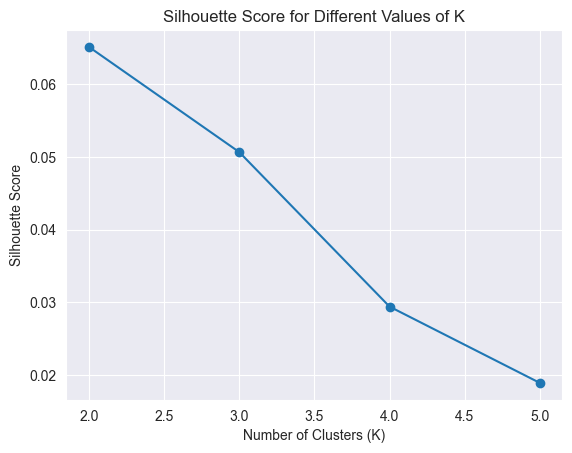

In [14]:
# Finding best value for K using silhouette coefficient
silhouette_scores = []

for k in range(2, 6):  # Adjust the range as needed
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(corpus_embeddings)
    silhouette_avg = silhouette_score(corpus_embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For K={k}, Silhouette Score: {silhouette_avg}")

# Plotting the silhouette scores
plt.plot(range(2, 6), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

In [13]:
# Training the K-Means clustering model
clustering_model = KMeans(n_clusters=4)
clustering_model.fit(encoded_reviews)

C:\Users\workspace\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\workspace\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\workspace\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


KMeans(n_clusters=4)

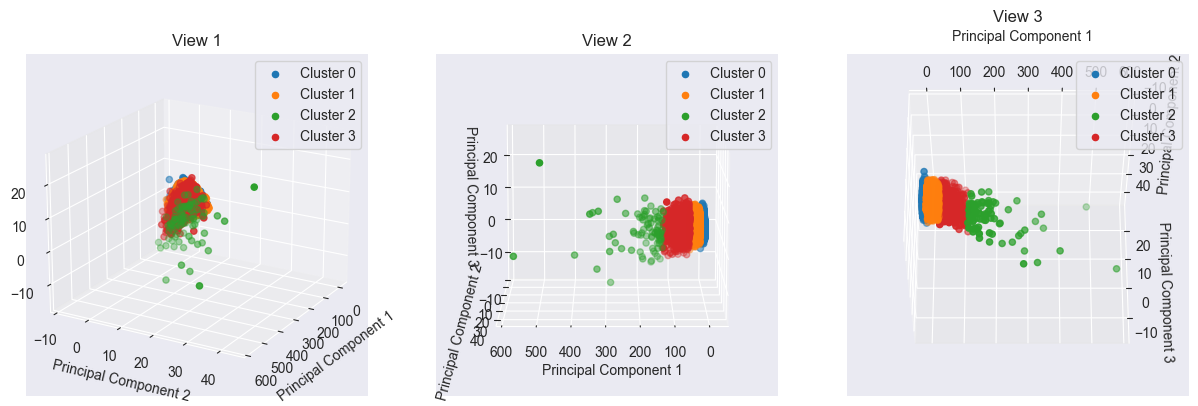

In [14]:
# Fit the PCA model to reduce dimensionality to 3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(encoded_reviews)

# Add cluster labels to the PCA results
pca_result_with_labels = np.column_stack((pca_result, clustering_model.labels_))

# Create a 3D scatter plot with multiple views
fig = plt.figure(figsize=(15, 5))

# Plot 1
ax1 = fig.add_subplot(131, projection='3d')
for label in set(clustering_model.labels_):
    indices = np.where(pca_result_with_labels[:, -1] == label)
    ax1.scatter(pca_result_with_labels[indices, 0], pca_result_with_labels[indices, 1], pca_result_with_labels[indices, 2], label=f'Cluster {label}')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')
ax1.set_title('View 1')
ax1.legend()
ax1.view_init(elev=20, azim=30)  # Adjust the elevation (elev) and azimuth (azim) angles

# Plot 2
ax2 = fig.add_subplot(132, projection='3d')
for label in set(clustering_model.labels_):
    indices = np.where(pca_result_with_labels[:, -1] == label)
    ax2.scatter(pca_result_with_labels[indices, 0], pca_result_with_labels[indices, 1], pca_result_with_labels[indices, 2], label=f'Cluster {label}')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('View 2')
ax2.legend()
ax2.view_init(elev=10, azim=90)  # Adjust the elevation (elev) and azimuth (azim) angles

# Plot 3
ax3 = fig.add_subplot(133, projection='3d')
for label in set(clustering_model.labels_):
    indices = np.where(pca_result_with_labels[:, -1] == label)
    ax3.scatter(pca_result_with_labels[indices, 0], pca_result_with_labels[indices, 1], pca_result_with_labels[indices, 2], label=f'Cluster {label}')
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')
ax3.set_zlabel('Principal Component 3')
ax3.set_title('View 3')
ax3.legend()
ax3.view_init(elev=-30, azim=-90)  # Adjust the elevation (elev) and azimuth (azim) angles

plt.show()

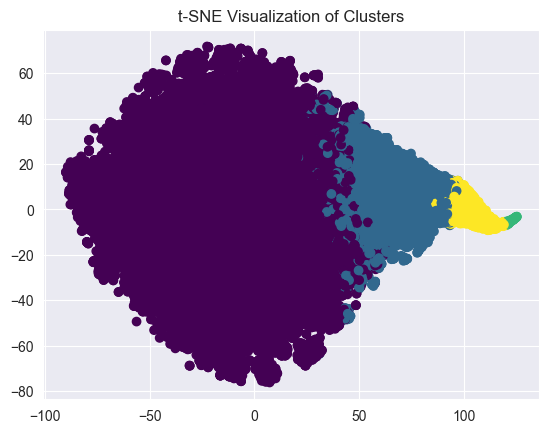

In [17]:
# 2D Visualization
tsne = TSNE(n_components=2, random_state=42)
embedded_clusters = tsne.fit_transform(encoded_reviews)

plt.scatter(embedded_clusters[:, 0], embedded_clusters[:, 1], c=clustering_model.labels_, cmap='viridis')
plt.title("t-SNE Visualization of Clusters")
plt.show()

In [18]:
# Inertia
inertia = clustering_model.inertia_
print(f"Inertia: {inertia}")

Inertia: 4120610.0


In [19]:
# Davies Bouldin Score
db_index = davies_bouldin_score(encoded_reviews, clustering_model.labels_)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.9375923603190905


In [20]:
# Calinski Harabasz Score
ch_index = calinski_harabasz_score(encoded_reviews, clustering_model.labels_)
print(f"Calinski-Harabasz Index: {ch_index}")

Calinski-Harabasz Index: 19154.576950845396
